# Stress Test : Analyse de risque de crédit – Portefeuille Alpha

## 1. Introduction

Ce projet s’inscrit dans une logique de **Risk Management / Data Science bancaire**, appliqué à la **Banque Alpha**, dans un contexte macroéconomique dégradé (**Stagflation Sévère 2026**).

L’objectif est de réaliser un **stress test global de portefeuille** pour :
- analyser la **sensibilité du portefeuille** aux chocs macroéconomiques,
- comparer deux secteurs stratégiques (Cyclic : **Construction**, Défensif : **Grande Distribution**),
- mesurer l’impact du stress sur la **Probabilité de Défaut (PD)** et la **Perte Attendue (EL)**.

Deux sous-portefeuilles sont simulés :
- **Construction** : 100 entreprises
- **Grande Distribution** : 30 entreprises

---

## 2. Méthodologie

Les étapes de l’analyse sont les suivantes :
1. Génération d’un portefeuille réaliste
2. Calcul des pertes attendues avant stress
3. Application du scénario de stress
4. Comparaison avant / après stress
5. Visualisation des résultats

---

## 3. Import des bibliothèques
(L’étape d’import sera lancée dans la cellule suivante.)


In [2]:
# =========================================
# Stress Test – Global Risk
# Auteur : Carole
# Environnement : JupyterLab (Anaconda)
# =========================================


In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Python :", sys.version)
print("NumPy :", np.__version__)
print("Pandas :", pd.__version__)


Python : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
NumPy : 1.26.4
Pandas : 2.2.2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Vérification des versions
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)
print("Seaborn version:", sns.__version__)


NumPy version: 1.26.4
Pandas version: 2.2.2
Matplotlib version: 3.9.2
Seaborn version: 0.13.2


In [31]:
import os

# Création du dossier 'data' s'il n'existe pas déjà
os.makedirs("data", exist_ok=True)

# Exemple de données du portefeuille
data = {
    'Secteur': ['Construction', 'Grande Distribution', 'Construction', 'Grande Distribution'],
    'Encours': [1500000, 2000000, 1200000, 1800000],
    'PD': [0.02, 0.01, 0.025, 0.015],
    'LGD': [0.45, 0.4, 0.5, 0.35]
}

# Création du DataFrame
df = pd.DataFrame(data)

# Sauvegarde dans le fichier CSV
df.to_csv("data/portefeuille_alpha.csv", index=False)

# Vérification
df.head()


,Secteur,Encours,PD,LGD
0,Construction,1500000,0.020,0.45
1,Grande Distribution,2000000,0.010,0.40
2,Construction,1200000,0.025,0.50
3,Grande Distribution,1800000,0.015,0.35


## 4. Chargement des données


In [8]:
# =======================================
# Étape 2 - Chargement des données
# =======================================

# Lecture du fichier CSV
df = pd.read_csv("data/portefeuille_alpha.csv")

# Aperçu des 5 premières lignes
df.head()


,Secteur,Encours,PD,LGD
0,Construction,1500000,0.020,0.45
1,Grande Distribution,2000000,0.010,0.40
2,Construction,1200000,0.025,0.50
3,Grande Distribution,1800000,0.015,0.35


## 5. Génération du portefeuille initial


Création aléatoire d’un portefeuille de 130 entreprises réparties entre les deux secteurs.


In [34]:
# Initialisation du générateur aléatoire pour reproductibilité
np.random.seed(42)

# 130 entreprises, moitié-moitié
n_total = 130
n_construction = n_total // 2
n_distribution = n_total - n_construction

# Fonctions utilitaires
def generate_names(prefix, n):
    return [f"{prefix}_{i+1}" for i in range(n)]

def random_notation():
    return np.random.choice(['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC'], p=[0.05, 0.1, 0.2, 0.25, 0.2, 0.15, 0.05])

# Génération des données
df_construction = pd.DataFrame({
    'NomEntreprise': generate_names("ConstructCo", n_construction),
    'Secteur': ['Construction'] * n_construction,
    'ChiffreAffaires': np.random.normal(loc=50, scale=10, size=n_construction).round(2),
    'Encours': np.abs(
    np.random.normal(loc=10, scale=3, size=n_construction)
).round(2),
   
})

df_distribution = pd.DataFrame({
    'NomEntreprise': generate_names("DistribuCorp", n_distribution),
    'Secteur': ['Grande Distribution'] * n_distribution,
    'ChiffreAffaires': np.random.normal(loc=70, scale=15, size=n_distribution).round(2),
    'Encours': np.abs(
    np.random.normal(loc=8, scale=2, size=n_distribution)
).round(2),

})

# Fusion
df = pd.concat([df_construction, df_distribution], ignore_index=True)

# Ajout des notations et des PD fictives
df['Notation'] = [random_notation() for _ in range(n_total)]
notation_pd_map = {
    'AAA': 0.01, 'AA': 0.03, 'A': 0.05, 'BBB': 0.1,
    'BB': 0.2, 'B': 0.4, 'CCC': 0.6
}
df['PD'] = df['Notation'].map(notation_pd_map)

# Affichage d’un extrait
df.head()


,NomEntreprise,Secteur,ChiffreAffaires,Encours,Notation,PD
0,ConstructCo_1,Construction,54.97,14.07,BBB,0.10
1,ConstructCo_2,Construction,48.62,9.78,AA,0.03
2,ConstructCo_3,Construction,56.48,13.01,BBB,0.10
3,ConstructCo_4,Construction,65.23,11.08,BBB,0.10
4,ConstructCo_5,Construction,47.66,8.06,A,0.05


## 6. Visualisation exploratoire

Afin de mieux comprendre la répartition des entreprises et des probabilités de défaut, nous affichons quelques graphiques descriptifs.

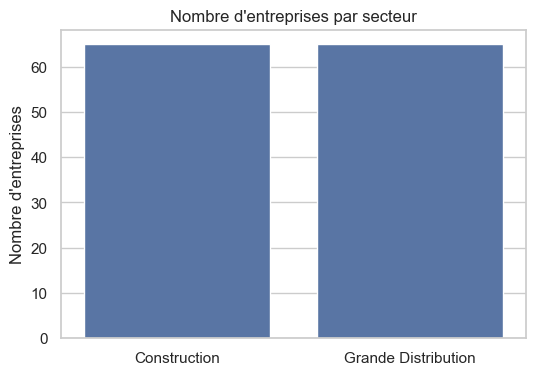

In [26]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Secteur')
plt.title("Nombre d'entreprises par secteur")
plt.xlabel("")
plt.ylabel("Nombre d'entreprises")
plt.show()


Ce graphique montre que les deux secteurs (Construction et Grande Distribution) comptent un nombre équivalent d’entreprises. Cela permet une comparaison équilibrée pour l’analyse de risque.


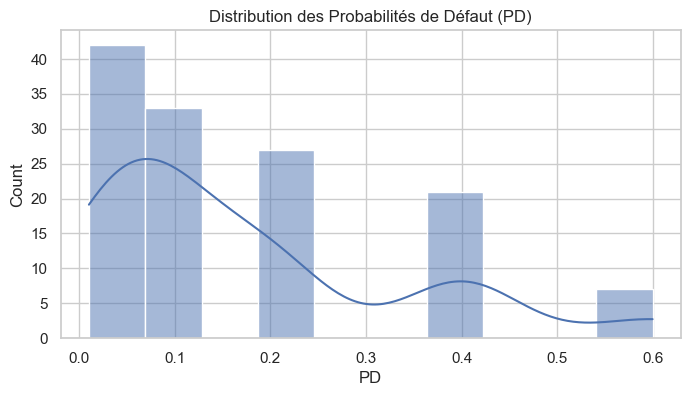

In [35]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='PD', bins=10, kde=True)
plt.title("Distribution des Probabilités de Défaut (PD)")
plt.show()


La majorité des entreprises présente une probabilité de défaut faible, ce qui suggère un portefeuille globalement sain, bien qu’une minorité ait un PD élevé.


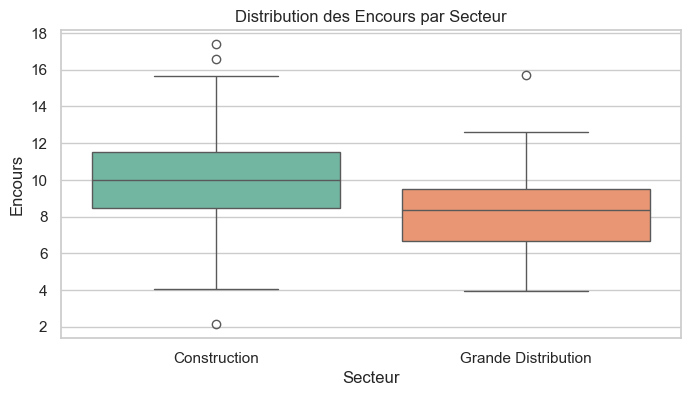

In [36]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=df,
    x='Secteur',
    y='Encours',
    hue='Secteur',
    palette='Set2',
    legend=False
)
plt.title("Distribution des Encours par Secteur")
plt.show()



Les encours sont plus dispersés dans le secteur de la Grande Distribution que dans la Construction, ce qui pourrait refléter une variabilité de taille ou de chiffre d'affaires parmi les entreprises.


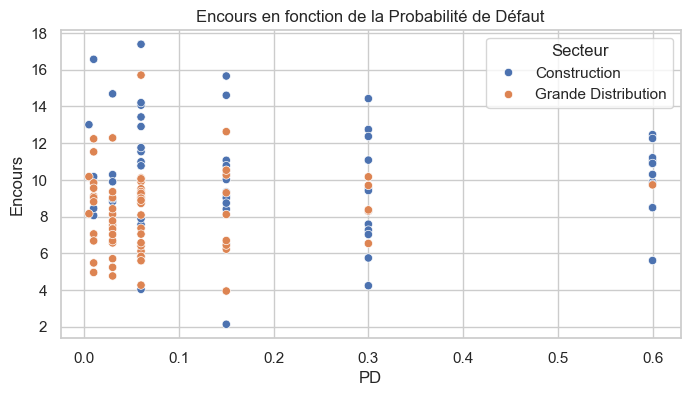

In [30]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df, x='PD', y='Encours', hue='Secteur')
plt.title("Encours en fonction de la Probabilité de Défaut")
plt.show()


Il n’y a pas de lien clair entre l’encours et la probabilité de défaut. Toutefois, on remarque que les entreprises à haut encours ne présentent pas nécessairement un risque plus élevé.


## 7. Calcul des indicateurs clés (PD, EL)


In [53]:
# Définition de la LGD par notation (Loss Given Default)
lgd_map = {
    'AAA': 0.20,
    'AA':  0.25,
    'A':   0.30,
    'BBB': 0.40,
    'BB':  0.50,
    'B':   0.60,
    'CCC': 0.70
}

df['LGD'] = df['Notation'].map(lgd_map)


In [40]:
df[['Notation', 'LGD']].head()


,Notation,LGD
0,BBB,0.40
1,AA,0.25
2,BBB,0.40
3,BBB,0.40
4,A,0.30


 Calcul de la Perte Attendue (Expected Loss)

In [54]:

df['PerteAttendue'] = df['PD'] * df['LGD'] * df['Encours']


In [56]:
df[['NomEntreprise',
    'Secteur',
    'Encours',
    'Notation',
    'PD',
    'LGD',
    'PerteAttendue']].head()


,NomEntreprise,Secteur,Encours,Notation,PD,LGD,PerteAttendue
0,ConstructCo_1,Construction,14.07,BBB,0.10,0.40,0.56280
1,ConstructCo_2,Construction,9.78,AA,0.03,0.25,0.07335
2,ConstructCo_3,Construction,13.01,BBB,0.10,0.40,0.52040
3,ConstructCo_4,Construction,11.08,BBB,0.10,0.40,0.44320
4,ConstructCo_5,Construction,8.06,A,0.05,0.30,0.12090


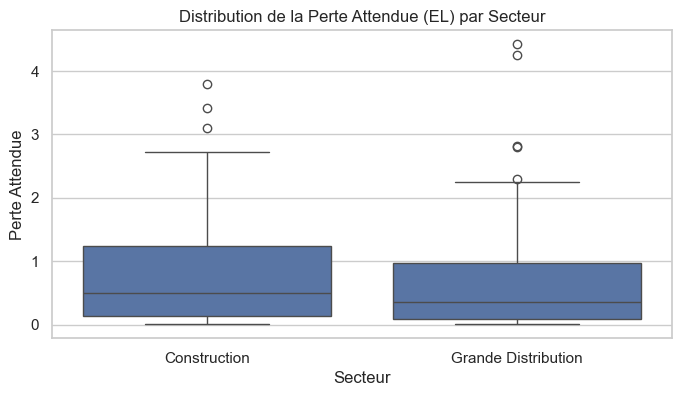

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='Secteur', y='PerteAttendue')
plt.title("Distribution de la Perte Attendue (EL) par Secteur")
plt.ylabel("Perte Attendue")
plt.xlabel("Secteur")
plt.show()


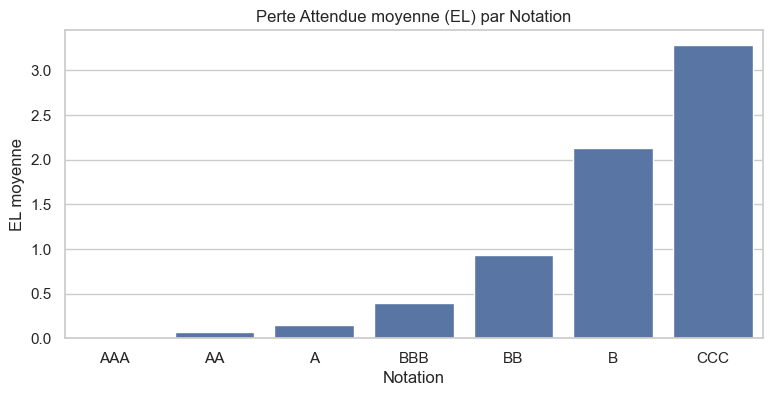

In [58]:
plt.figure(figsize=(9,4))
ordre = ['AAA','AA','A','BBB','BB','B','CCC']
sns.barplot(data=df, x='Notation', y='PerteAttendue', order=ordre, errorbar=None)
plt.title("Perte Attendue moyenne (EL) par Notation")
plt.ylabel("EL moyenne")
plt.xlabel("Notation")
plt.show()


Affichage d'un extrait avec les nouvelles colonnes

In [50]:

df[['NomEntreprise', 'Secteur', 'Encours', 'Notation', 'PD', 'LGD', 'PerteAttendue']].head()



,NomEntreprise,Secteur,Encours,Notation,PD,LGD,PerteAttendue
0,ConstructCo_1,Construction,14.07,BBB,0.10,0.40,0.56280
1,ConstructCo_2,Construction,9.78,AA,0.03,0.25,0.07335
2,ConstructCo_3,Construction,13.01,BBB,0.10,0.40,0.52040
3,ConstructCo_4,Construction,11.08,BBB,0.10,0.40,0.44320
4,ConstructCo_5,Construction,8.06,A,0.05,0.30,0.12090


In [11]:
df.head(10)


,NomEntreprise,Secteur,ChiffreAffaires,Encours,Notation,PD
0,ConstructCo_1,Construction,54.97,14.07,BBB,0.060
1,ConstructCo_2,Construction,48.62,9.78,CCC,0.600
2,ConstructCo_3,Construction,56.48,13.01,AAA,0.005
3,ConstructCo_4,Construction,65.23,11.08,CCC,0.600
4,ConstructCo_5,Construction,47.66,8.06,AA,0.010
5,ConstructCo_6,Construction,47.66,11.08,B,0.300
6,ConstructCo_7,Construction,65.79,14.61,BB,0.150
7,ConstructCo_8,Construction,57.67,9.89,CCC,0.600
8,ConstructCo_9,Construction,45.31,14.69,A,0.030
9,ConstructCo_10,Construction,55.43,2.14,BB,0.150


In [12]:
df['Notation'].value_counts()


Notation
BBB    36
BB     24
A      19
AA     17
B      17
CCC    14
AAA     3
Name: count, dtype: int64

In [59]:
# Calcul de la Perte Attendue
df['PerteAttendue'] = df['PD'] * df['LGD'] * df['Encours']

# Affichage d’un extrait pour vérifier
df[['NomEntreprise', 'Secteur', 'Encours', 'PD', 'PerteAttendue']].head(10)


,NomEntreprise,Secteur,Encours,PD,PerteAttendue
0,ConstructCo_1,Construction,14.07,0.10,0.56280
1,ConstructCo_2,Construction,9.78,0.03,0.07335
2,ConstructCo_3,Construction,13.01,0.10,0.52040
3,ConstructCo_4,Construction,11.08,0.10,0.44320
4,ConstructCo_5,Construction,8.06,0.05,0.12090
5,ConstructCo_6,Construction,11.08,0.10,0.44320
6,ConstructCo_7,Construction,14.61,0.10,0.58440
7,ConstructCo_8,Construction,9.89,0.20,0.98900
8,ConstructCo_9,Construction,14.69,0.20,1.46900
9,ConstructCo_10,Construction,2.14,0.01,0.00428


               Secteur  PerteAttendue
0         Construction      144.85755
1  Grande Distribution       45.26380


C:\Users\carol\AppData\Local\Temp\ipykernel_12856\2050332128.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pertes_par_secteur, x='Secteur', y='PerteAttendue', palette='Set2')


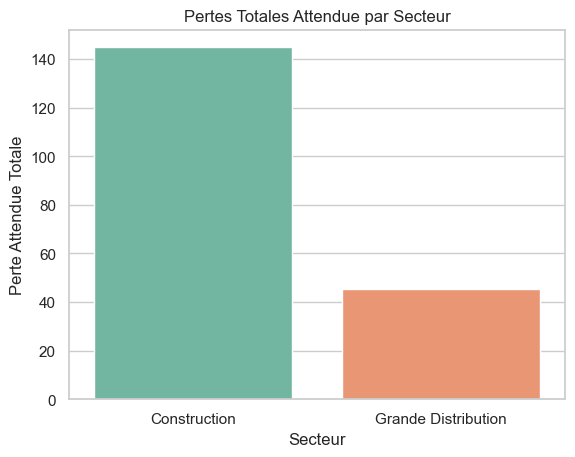

In [14]:
# Calcul de la perte totale par secteur
pertes_par_secteur = df.groupby('Secteur')['PerteAttendue'].sum().reset_index()

# Affichage
print(pertes_par_secteur)

# Optionnel : Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=pertes_par_secteur, x='Secteur', y='PerteAttendue', palette='Set2')
plt.title("Pertes Totales Attendue par Secteur")
plt.ylabel("Perte Attendue Totale")
plt.xlabel("Secteur")
plt.show()


In [15]:
df_stress = df.copy()


In [16]:
# Application du stress : augmentation des PD
df_stress.loc[df_stress['Secteur'] == 'Construction', 'PD'] *= 1.3
df_stress.loc[df_stress['Secteur'] == 'Grande Distribution', 'PD'] *= 1.1


In [61]:
# Recalcul de la LGD dans le dataframe stressé
df_stress['LGD'] = df_stress['Notation'].map(lgd_map)

# Recalcul de la Perte Attendue après stress
df_stress['PerteAttendue'] = df_stress['PD'] * df_stress['LGD'] * df_stress['Encours']




In [18]:
# Pertes totales avant stress
pertes_avant = df.groupby('Secteur')['PerteAttendue'].sum().reset_index()
pertes_avant.rename(columns={'PerteAttendue': 'PerteAvantStress'}, inplace=True)

# Pertes totales après stress
pertes_apres = df_stress.groupby('Secteur')['PerteAttendue'].sum().reset_index()
pertes_apres.rename(columns={'PerteAttendue': 'PerteApresStress'}, inplace=True)

# Fusion des deux pour comparaison
comparaison = pd.merge(pertes_avant, pertes_apres, on='Secteur')
comparaison['Variation (%)'] = ((comparaison['PerteApresStress'] - comparaison['PerteAvantStress']) / comparaison['PerteAvantStress']) * 100

comparaison


,Secteur,PerteAvantStress,PerteApresStress,Variation (%)
0,Construction,144.85755,188.314815,30.0
1,Grande Distribution,45.26380,49.790180,10.0


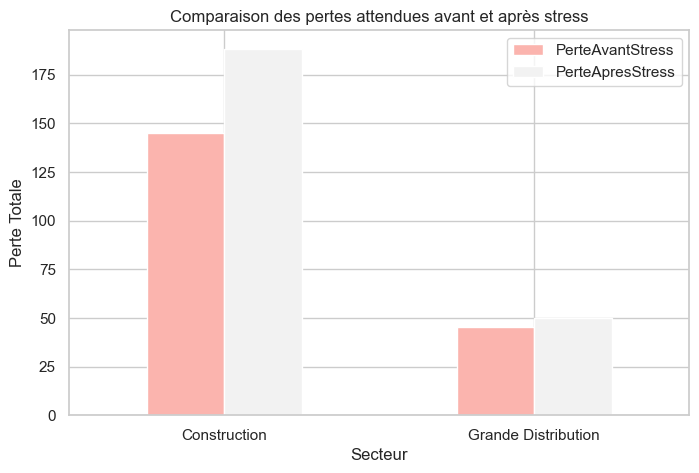

In [19]:
comparaison.plot(
    x='Secteur', 
    y=['PerteAvantStress', 'PerteApresStress'], 
    kind='bar', 
    figsize=(8,5), 
    colormap='Pastel1'
)
plt.title('Comparaison des pertes attendues avant et après stress')
plt.ylabel('Perte Totale')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


## 8. Extension du portefeuille – Simulation élargie


In [62]:
import numpy as np
import pandas as pd

np.random.seed(42)  # reproductibilité

n_total = 130

# Répartition sectorielle (exemple réaliste)
secteurs = np.random.choice(
    ['Construction', 'Grande Distribution'],
    size=n_total,
    p=[0.55, 0.45]
)

# Notations possibles
notations = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC']

# Probabilités de notation par secteur (guidées métier)
proba_notation_construction = [0.02, 0.05, 0.15, 0.28, 0.25, 0.15, 0.10]
proba_notation_distribution = [0.05, 0.15, 0.30, 0.30, 0.12, 0.06, 0.02]

notations_simulees = []
for s in secteurs:
    if s == 'Construction':
        notations_simulees.append(
            np.random.choice(notations, p=proba_notation_construction)
        )
    else:
        notations_simulees.append(
            np.random.choice(notations, p=proba_notation_distribution)
        )

# Encours simulés (en millions, positifs)
encours = np.round(
    np.abs(np.random.normal(loc=10, scale=4, size=n_total)),
    2
)

# Chiffre d'affaires simulé (optionnel, cohérent avec l'encours)
chiffre_affaires = np.round(encours * np.random.uniform(1.5, 3.0, size=n_total), 2)

# DataFrame simulé
df_simule = pd.DataFrame({
    'Secteur': secteurs,
    'Notation': notations_simulees,
    'Encours': encours,
    'ChiffreAffaires': chiffre_affaires
})

df_simule.head()


,Secteur,Notation,Encours,ChiffreAffaires
0,Construction,BBB,10.23,27.49
1,Grande Distribution,A,5.43,14.58
2,Grande Distribution,AA,11.43,18.71
3,Grande Distribution,A,12.24,27.44
4,Construction,CCC,14.33,22.73


In [63]:
# Mapping PD par notation (déjà utilisé plus haut)
df_simule['PD'] = df_simule['Notation'].map(notation_pd)

# Mapping LGD par notation (déjà utilisé plus haut)
df_simule['LGD'] = df_simule['Notation'].map(lgd_map)

# Calcul de la Perte Attendue
df_simule['PerteAttendue'] = df_simule['PD'] * df_simule['LGD'] * df_simule['Encours']

df_simule.head()


,Secteur,Notation,Encours,ChiffreAffaires,PD,LGD,PerteAttendue
0,Construction,BBB,10.23,27.49,0.06,0.40,0.245520
1,Grande Distribution,A,5.43,14.58,0.03,0.30,0.048870
2,Grande Distribution,AA,11.43,18.71,0.01,0.25,0.028575
3,Grande Distribution,A,12.24,27.44,0.03,0.30,0.110160
4,Construction,CCC,14.33,22.73,0.60,0.70,6.018600


In [64]:
df_simule.shape


(130, 7)

In [65]:
df_simule.groupby('Secteur')['Encours'].sum()


Secteur
Construction           811.02
Grande Distribution    545.39
Name: Encours, dtype: float64

In [66]:
df_simule['Notation'].value_counts(normalize=True).round(2)


Notation
BB     0.25
BBB    0.25
A      0.22
B      0.11
AA     0.07
CCC    0.06
AAA    0.05
Name: proportion, dtype: float64